In [1]:
import random
import torch
import math
import torch.optim as optim
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
from torch.autograd import Variable
from model_cnn_v2 import MyCNN2
from model_cnn import MyCNN
from dataset import MyDataset
from functools import reduce
from torch.utils.data import DataLoader
from torch.nn.functional import pad 
from tensorboard_logger import configure, log_value, log_histogram
from shared import (squadIteratorGraph, readDicFromFile, loadSparseM, 
                    myTokenizer,
                    initEdgeVectors, mkGraph, nearestNodes, processOneExample, 
                    readFrequencyFile,
                    getDistanceMatrix,
                    _distancesOneToMany,
                    spanDistance,
                    movingaverage,
                    cosDist,
                    getSublists, sublist)

vocab = readDicFromFile('vocab500K')
matrix = loadSparseM('matrix_500K_sc4_reduced')
freq_dict = readFrequencyFile("freq_vocab500K")
trainIter = squadIteratorGraph('train-v1.1.json', vocab, matrix, freq_dict)
model = MyCNN2()
model_old = MyCNN()
SPAN_LEN = 20

CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if CUDA else torch.FloatTensor
if CUDA:
    print("CUDA is available. Move model to GPU.")
    model.cuda()

# Dataset for evaluation
dsEval = MyDataset("dev-v1.1.json", 10, vocab, matrix, span_len=SPAN_LEN)
dataloaderEval = DataLoader(dsEval, batch_size=1, shuffle=True, num_workers=1)

# tensorboard logger config https://github.com/TeamHG-Memex/tensorboard_logger
dt = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
configure(f"runs/{dt}", flush_secs=5)

--- 1.3044161796569824 time ---


In [2]:
def evalModel(model, dataloaderEval, dtype = None):
    '''Evaluate the Model'''
    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    
    
    positive = [(x,y) for (x,y) in dataloaderEval if (y == True).sum() == 1]
    negative = [(x,y) for (x,y) in dataloaderEval if (y == False).sum() == 1][0:len(positive)]
    #print(len(positive))
    #print(len(negative))
    correct = 0
    total = 0
    for X, Y in positive + negative:
        Y = Y.view(-1)
        X = Variable(X.type(dtype), requires_grad = False)
        
        outputs = model(X).view(-1)
        correct += ((outputs.data > 0.5) == Y).sum()
        total += Y.size(0)
        #print(outputs.size())
        #correct += (predicted == labels).sum()
    #print(correct, total)
    print('Test Accuracy of the model on the %d test images: %d %%' % (total, 100 * correct / total))
    model.train()
    return correct / total

In [461]:
(gr, idxs), answer, question, paragraph = next(trainIter)
print("P: ", paragraph)
print("Q: ", question)
print("A: ", answer)

P:  Her first acting role of 2006 was in the comedy film The Pink Panther starring opposite Steve Martin, grossing $158.8 million at the box office worldwide. Her second film Dreamgirls, the film version of the 1981 Broadway musical loosely based on The Supremes, received acclaim from critics and grossed $154 million internationally. In it, she starred opposite Jennifer Hudson, Jamie Foxx, and Eddie Murphy playing a pop singer based on Diana Ross. To promote the film, Beyoncé released "Listen" as the lead single from the soundtrack album. In April 2007, Beyoncé embarked on The Beyoncé Experience, her first worldwide concert tour, visiting 97 venues and grossed over $24 million.[note 1] Beyoncé conducted pre-concert food donation drives during six major stops in conjunction with her pastor at St. John's and America's Second Harvest. At the same time, B'Day was re-released with five additional songs, including her duet with Shakira "Beautiful Liar".
Q:  The single, "Listen" was featured 

In [462]:
distanceMatrix, dm_word_idx_map = getDistanceMatrix(matrix, paragraph, question, vocab)

# for idx, sentence in enumerate(paragraph.split('.')):
#     if (sentence == ''): continue
#     d = spanDistance(sentence, question, distanceMatrix, dm_word_idx_map)
#     print(f'sentence #{idx} has distance {d}')

In [463]:
#for idx, s in enumerate(paragraph.split('.')):
    #print(f'{idx} {s} \n')

In [464]:
#print(spanDistance('Begun', question, distanceMatrix, dm_word_idx_map))
#print(spanDistance('Next to the Main Building is the Basilica of the Sacred Heart drive', question, distanceMatrix, dm_word_idx_map))
#print(spanDistance('in front of is a copper statue', question, distanceMatrix, dm_word_idx_map))

In [465]:
p_tokens = myTokenizer(paragraph, POS=True, ACCUM_POS=False)
q_tokens = myTokenizer(question, POS=True, ACCUM_POS=False)
a_tokens = myTokenizer(answer, POS=True, ACCUM_POS=False)
values = []
tokens = []

for (w, pos) in p_tokens: 
    
    if pos == '<NNP>':
        if (w, pos) in q_tokens:
            values.append(0)
        else:
            without_nnp = list(map(lambda v: v[0] if v[1] != '<NUM>' else '<NUM>', filter(lambda v: v[1] not in ['<NNP>'], q_tokens)))
            ds = _distancesOneToMany('<NNP>', without_nnp, distanceMatrix, dm_word_idx_map)
            v = min(ds)
            values.append(v)
        tokens.append(pos + ' ' + w)
    elif pos == '<NUM>':
        if (w, pos) in q_tokens:
            values.append(0)
        else:
            without_nums = list(map(lambda v: v[0] if v[1] != '<NNP>' else '<NNP>', filter(lambda v: v[1] not in ['<NUM>'], q_tokens)))
            ds = _distancesOneToMany('<NUM>', without_nums, distanceMatrix, dm_word_idx_map)
            v = min(ds)
            values.append(v)
        tokens.append(pos  + ' ' + w)
    else:
        
        #if w in dm_word_idx_map: continue
        #print(w, pos)
        if w not in vocab: continue
        ts = list(map(lambda v: v[0], filter(lambda v: v[1] not in ['<NNP>', '<NUM>'], q_tokens)))
        ds = _distancesOneToMany(w, ts, distanceMatrix, dm_word_idx_map)
        v = min(ds)
        values.append(v)
        tokens.append(w)


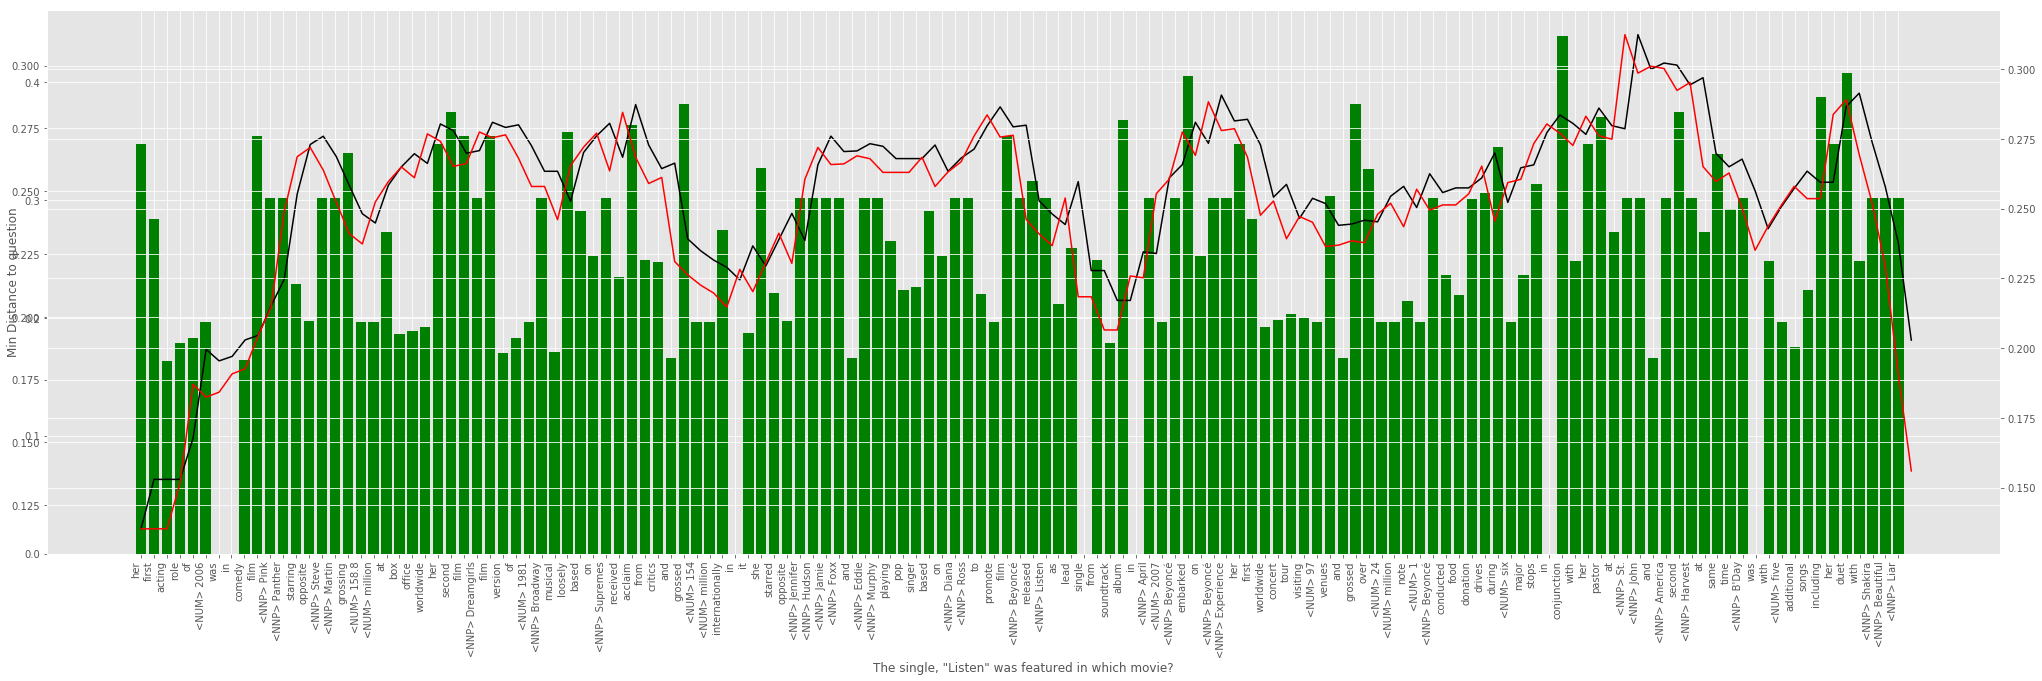

In [483]:
plt.style.use('ggplot')

x = tokens
energy = values

x_pos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(35, 10))
plt.bar(x_pos, energy, color='green')
plt.xlabel(question)
plt.ylabel("Min Distance to question")


# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.xticks(x_pos, x)

x2 = np.linspace(0, len(x_pos), num=len(x_pos))
y2 = movingaverage(energy, 10)


x3 = np.linspace(0, len(x_pos), num=len(x_pos))
y3 = movingaverage(energy[::-1], 10)[::-1]

axes2 = plt.twinx()
axes2.plot(x2, y2, color='k', label='MA1')
axes3 = plt.twinx()
axes3.plot(x3, y3, color='r', label='MA2')

plt.show()

In [8]:
# SPAN_LEN = 15

# p_spans = getSublists(p_tokens, SPAN_LEN)
# v_spans = getSublists(values, SPAN_LEN)

# train_smpls = list(map(lambda v: (sublist(a_tokens, v[0]), v[0], v[1]), zip(p_spans, v_spans)))


In [9]:
sublist([('Saint', '<NNP>'), ('Bernadette', '<NNP>'), ('Soubirous', '<NNP>')], [('grotto', 'NN'),
  ('at', 'IN'),
  ('Lourdes', '<NNP>'),
  ('France', '<NNP>'),
  ('where', 'WRB'),
  ('Virgin', '<NNP>'),
  ('Mary', '<NNP>'),
  ('reputedly', 'RB'),
  ('appeared', 'VBD'),
  ('to', 'TO'),
  ('Saint', '<NNP>'),
  ('Bernadette', '<NNP>'),
  ('Soubirous', '<NNP>'),
  ('in', 'IN'),
  ('1858', '<NUM>')])

True

In [2]:

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)
model.train()
learning_rate = 0.001
num_epochs = 1
batch_size = 13


ds = MyDataset("train-v1.1.json", 50, vocab, matrix, span_len=SPAN_LEN)
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

[pos_count, neg_count] = reduce(lambda accum, v: (accum[0] + 1, accum[1]) if v[1].tolist()[0] == 1 else  (accum[0], accum[1] + 1), ds, [0,0])
print([pos_count/len(ds), neg_count/len(ds)])
# Loss and Optimizer
criterion = torch.nn.BCELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the Model
step = 0;
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    for i, (X, Y) in enumerate(dataloader):
        #Y = Y.to(device)
        #X = X.to(device)
        
        Y = Y.type(dtype).view(-1)
        W = ((Y == False).float() * (pos_count / len(ds))) + ((Y == True).float()  * (neg_count / len(ds)))
        X = Variable(X.type(dtype), requires_grad = False)
        Y = Variable(Y.float(), requires_grad = False)
        
        #print(Y, W)
        criterion.weight = W
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(X).view(-1)
        #print("outputs.size=", outputs.size())
        #print("Y.size=", Y.size())
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        
        log_value('loss', loss.data[0], step) # log to tensorboard
        step+=1
    
    # eval model every N epoch
    if (epoch + 1) % 10 == 0:
        accuracy = evalModel(model, dataloaderEval)
        log_value('accuracy', accuracy, epoch) # log to tensorboard
        

        
        
    
        #         for name, param in model.named_parameters():
#             log_histogram(name, param.view(1, -1).data,  step=epoch*len(ds) + i)
  
    
    
#         if (i+1) % 100 == 0:
#             print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
#                    %(epoch+1, num_epochs, i+1, len(ds)//batch_size, loss.data[0]))

KeyboardInterrupt: 

In [4]:
evalModel(model, dataloaderEval)

Test Accuracy of the model on the 1593 test images: 99 %


0.9962335216572504

In [2]:
learning_rate = 0.001
num_epochs = 1000
batch_size = 13


ds = MyDataset("train-v1.1.json", 50, vocab, matrix, span_len=SPAN_LEN)
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)
[pos_count, neg_count] = reduce(lambda accum, v: (accum[0] + 1, accum[1]) if v[1].tolist()[0] == 1 else  (accum[0], accum[1] + 1), ds, [0,0])


for epoch in range(num_epochs):
    model.trainModel(dataloader, pos_count/len(ds), neg_count/len(ds), log_value)
    if (epoch + 1) % 10 == 0: log_value('accuracy', model.evaluateModel(dataloaderEval), epoch)
    for name, param in model.named_parameters(): 
        log_histogram(name, param.view(1, -1).data,  step=epoch)


--- 7.922329902648926 time ---
--- 19.665605068206787 Total time  ---
--- 18.702226877212524 Train time  ---
--- 21.075443744659424 Total time  ---
--- 19.86409640312195 Train time  ---


Process Process-10:
Process Process-12:
Process Process-11:
Traceback (most recent call last):
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get(

KeyboardInterrupt: 

In [4]:
for p,v in model.named_parameters():
    print(p,v.size())

cnn_paragraph.0.weight torch.Size([32, 1, 3])
cnn_paragraph.0.bias torch.Size([32])
cnn_paragraph.2.weight torch.Size([32, 32, 3])
cnn_paragraph.2.bias torch.Size([32])
cnn_paragraph.5.weight torch.Size([64, 32, 3])
cnn_paragraph.5.bias torch.Size([64])
cnn_paragraph.7.weight torch.Size([64, 64, 3])
cnn_paragraph.7.bias torch.Size([64])
cnn_span.0.weight torch.Size([16, 1, 3])
cnn_span.0.bias torch.Size([16])
cnn_span.2.weight torch.Size([16, 16, 3])
cnn_span.2.bias torch.Size([16])
cnn_span.5.weight torch.Size([32, 16, 3])
cnn_span.5.bias torch.Size([32])
cnn_span.7.weight torch.Size([32, 32, 3])
cnn_span.7.bias torch.Size([32])
fcn.0.weight torch.Size([32, 96])
fcn.0.bias torch.Size([32])
fcn.2.weight torch.Size([1, 32])
fcn.2.bias torch.Size([1])


In [474]:
print(movingaverage([1,2,3,4,5][::-1],2)[::-1])
print(movingaverage([1,2,3,4,5],2))

[ 1.5  2.5  3.5  4.5  2.5]
[ 0.5  1.5  2.5  3.5  4.5]
